Cosumnes Model 
@author: Andrew

In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.2
matplotlib version: 3.5.0
flopy version: 3.3.4


In [6]:
# loadpth = 'C://WRDAPP/GWFlowModel'
# all_model_ws = loadpth+'/Cosumnes_simple/WEL_SFR_RCH_layercake'

# # model_ws = loadpth+'/ButteValley_tr_parallel'

# # model_ws = loadpth+'/ButteValley_tr'

# m = flopy.modflow.Modflow.load('MF.nam', model_ws=all_model_ws, 
#                                 exe_name='mf2005', version='mf2005')

# # HOB package is not necessary for scenario testing
# m.remove_package('HOB')
# m.remove_package('SFR') # remove sfr package to avoid issue with tab file extension?

## Reuse the steady state period from the 2018-2019 period
No change is needed for the LPF, BAS6, OC, or PCGN packages

In [7]:
# can resuse the steady state from the WEL, RCH (UZF), GHB and CHD packages
wel0 = m.wel.stress_period_data[0]
ghb0 = m.ghb.stress_period_data[0]
chd0 = m.chd.stress_period_data[0]

# may need to switch out with UZF later
rch0 = m.rch.rech.array[0,0,:,:]

# save bottom and top definitions for rewriting DIS package
botm = m.dis.botm.array
top = m.dis.top.array

In [8]:

# arbitrary start date
strt_date = '2018-01-01'

# one steady state and 10 transient period of 1 day to find an equilibrium lake stage
nper = 1 + 20
# steady state period of 1 day for unit simplicity
perlen = np.ones(nper)
# Steady state period, followed by 10 transient periods
steady = np.zeros(nper)
steady[0] = 1
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
nstp = 6*np.ones(nper)

In [9]:
#Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
nrow=100
ncol=230
delr=200
delc=200
rotation=52.9

# The number of layers should be 1 for the Mehrten formation, 1 for the laguna plus the number of TPROGS layers,
# where the Laguna formation will be clipped by the TPROGS layers
# num_tprogs = 120
num_tprogs=1
nlay = 2 + num_tprogs
# tprog_thick = 0.5
tprog_thick = 120*0.5


# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

In [7]:
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'GitHub':
    git_dir = os.path.dirname(git_dir)
usr_dir = os.getcwd()
while os.path.basename(usr_dir) != 'Users':
    temp = os.path.basename(usr_dir)
    usr_dir = os.path.dirname(usr_dir)
usr_dir += '/'+temp

## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users/ajcalder/Box/research_cosumnes/GWFlowModel'

In [11]:
from flopy.utils.geometry import Polygon, LineString, Point
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

In [12]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
#                           version = 'mf2005', model_ws=model_ws)
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds

dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date, botm = botm, top = top)
# create new discretization package with 1 steady state period


In [13]:
# load package with the SS period
ghb = flopy.modflow.ModflowGhb(model=m, stress_period_data = ghb0,ipakcb=55)
chd = flopy.modflow.ModflowChd(model=m, stress_period_data = chd0,ipakcb=55)
rch = flopy.modflow.ModflowRch(model=m, rech = rch0,ipakcb=55)
wel = flopy.modflow.ModflowWel(model=m, stress_period_data = wel0,ipakcb=55)

In [14]:
m.get_package_list()
# m.dis.nper


['DIS', 'BAS6', 'LPF', 'GHB', 'CHD', 'RCH', 'WEL', 'OC', 'PCGN']

In [15]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
# print(gwfm_dir)

# Find Michigan Bar location
# mb_gpd = sensors[sensors.Sensor_id == "MI_Bar"]
# mb_grid = gpd.sjoin(mb_gpd, grid_p, how = 'left', op = 'intersects')

In [16]:
# K values are in m/s
scaling_factors = pd.read_csv(all_model_ws+'/GHB_UZF_WEL_scaling.csv',delimiter = ',')



## Import soil data for Lake Package, UZF Package, SFR Package hydraulic parameters

In [10]:
mb_name = gwfm_dir+"/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"

mb = gpd.read_file(mb_name)
mb = mb.to_crs('epsg:32610')

In [11]:
uzf_path = gwfm_dir+'\\UZF_data'
soil_path = uzf_path+'\\wss_gsmsoil_CA'
# # Read in the soil map spatial data
# soil_gpd = gpd.read_file(uzf_path+'\\wss_gsmsoil_CA\\spatial\\gsmsoilmu_a_ca.shp')
# soil_gpd = soil_gpd.to_crs('EPSG:32610')
# # soil_gpd.plot()

### Write grid_uzf to shapefile to avoid having to repeat analysis

In [12]:
# grid_uzf.to_file(uzf_path+'/final_grid_uzf/griduzf.shp')
# grid_uzf = gpd.read_file(uzf_path+'/final_grid_uzf/griduzf.shp')

In [13]:
# def fill_uzf(uzfvalues, grid_uzf):
#     # convert geopandas object to regular np array for soil data
#     temp = np.zeros((nrow,ncol))
#     temp[(grid_uzf.row.values-1).astype(int),(grid_uzf.column.values-1).astype(int)] = uzfvalues
#     return(temp)

In [14]:
soilKs_array = np.loadtxt(uzf_path+'/final_soil_arrays/final_soilKs.tsv', delimiter = '\t')
soiln_array = np.loadtxt(uzf_path+'/final_soil_arrays/final_soiln.tsv', delimiter = '\t')
soileps_array = np.loadtxt(uzf_path+'/final_soil_arrays/final_soileps.tsv', delimiter = '\t')
soildepth_array = np.loadtxt(uzf_path+'/final_soil_arrays/final_soildepth.tsv', delimiter = '\t')

# soilKs_array = fill_uzf(grid_uzf.Ksat_Rep, grid_uzf)
# soiln_array = fill_uzf(grid_uzf.Porosity_R, grid_uzf)
# soileps_array = fill_uzf(grid_uzf.EPS, grid_uzf)

# np.savetxt(uzf_path+'/final_soilKs.tsv', soilKs_array, delimiter = '\t')
# np.savetxt(uzf_path+'/final_soiln.tsv', soiln_array, delimiter = '\t')
# np.savetxt(uzf_path+'/final_soileps.tsv', soileps_array, delimiter = '\t')

## Reload already set steady state model

In [15]:
loadpth = 'C://WRDAPP/GWFlowModel/Cosumnes_Blodgett_scenarios/'
model_ws = loadpth +'new_0025cfs'
m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf2005', version='mf2005')

In [16]:
m.get_package_list()
m.remove_package('SFR')

# SFR

In [8]:
# gwfm_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sfr = m.sfr
sfr_dir = gwfm_dir+'/SFR_data/'

In [9]:
# grid_sfr.to_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

## Adjust Blodgett Dam scenario here

In [67]:
# scenario = 'design'
# scenario = 'actual'
scenario = 'new'


In [68]:
# XSlocs = gpd.read_file(sfr_dir+'8pointXS_locs/8pointXS_locs.shp')
# new shapefile with an extra point for blodgett dam as site 16.5
XSlocs = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/8pointXS_locs/8pointXS_locs.shp')
XSlocs.crs = 32610

XSg  = gpd.sjoin(grid_sfr, XSlocs, how = "inner", op= "contains", lsuffix = 'sfr',rsuffix = 'xs')
# print(len(XSg))

# # Append the grid_breach location to the list of cross sections to split the segment
# XSg = XSg.append(grid_breach).sort_values('reach')
# # Copy the XS site name from the previous last site to the breach site to keep same XS
# XSg.Site.iloc[-1] = XSg.Site.iloc[-2]
# len(XSg), len(XS8pt.loc[0,:])/2

# for all scenarios there will be a new XS 16.5 representing the XS just after the dam
# and a new XS 16.2 just before the dam for routing/diversion programming
# XS 16.4 represents the side channel for teh actual scenario and the recontoured XS for the new scenario
if (scenario == 'actual')|(scenario=='new'):
    XSg_side = XSg.loc[XSg.Site==16.5]
    XSg_side.loc[:,'Site'] = 16.4
    XSg = XSg.append(XSg_side)
if scenario=='actual':
    XSg_rout = XSg.loc[XSg.Site==16.5]
    XSg_rout.loc[:,'Site'] = 16.3
    XSg = XSg.append(XSg_rout)
# if the scneario is the restructured or designed dam then no change in the segments is necessary
# sort by site to make sure any XS added are properly included
XSg = XSg.sort_values('Site')
# print(len(XSg))


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [69]:
# segment 16.2 is just an extra artificial reach to help with diversion
# since it exists in the actual and design scenario it should be kept in the new scenario as well for uniformity in recharge
# if (scenario =='actual') | (scenario=='design'):
# keep extra short segment before dam for now in case needed for later and for consistency in stream leakage
pre_rch_num = XSg.loc[XSg.Site==16.2,'reach'].iloc[0]
add_rch = grid_sfr.loc[grid_sfr.reach== pre_rch_num].copy()
# for all reaches after added reach, need to add 1 to the reach number
grid_sfr.loc[grid_sfr.reach>pre_rch_num,'reach'] = grid_sfr.loc[grid_sfr.reach>pre_rch_num,'reach'] +1
# using the desired reach add 1 to just the duplicate
add_rch.reach +=1
# extra channel is 10m in length because it is there just to allow transfer of flow
grid_sfr.loc[grid_sfr.reach== pre_rch_num,'length_m'] = 10
add_rch.z = add_rch.z-10*add_rch.slope # adjust elevation of added reach to account for slope required
grid_sfr = grid_sfr.append(add_rch).sort_values('reach')
# adjust XSg to account for chnages to grid_sfr
XSg.loc[XSg.reach>pre_rch_num,'reach'] +=1
XSg.loc[XSg.Site==16.2,'reach']+=1 #add one to 16.2 because can't have two of the same reach
   
    
if scenario=='actual':
       # need to duplicate the side channel reach for the segment
    add_rch_num = XSg.loc[XSg.Site==16.3,'reach'].iloc[0]
    add_rch = grid_sfr.loc[grid_sfr.reach== add_rch_num].copy()
    # for all reaches after added reach, need to add 1 to the reach number
    grid_sfr.loc[grid_sfr.reach>add_rch_num,'reach'] = grid_sfr.loc[grid_sfr.reach>add_rch_num,'reach'] +1
    # using the desired reach add 1 to just the duplicate
    add_rch.reach +=1

    # side channel is 70m in length from satellite
    # length of reach after dam can be kept the same but could be reduced slightly to account for addition of flooding/lake
    grid_sfr.loc[grid_sfr.reach== add_rch_num,'length_m'] = 5
    add_rch.z = add_rch.z-5*add_rch.slope # adjust elevation of added reach to account for slope required
    grid_sfr = grid_sfr.append(add_rch).sort_values('reach')
    
    # adjust XSg to account for chnages to grid_sfr
    XSg.loc[XSg.reach>add_rch_num,'reach'] +=1
    XSg.loc[XSg.Site==16.4,'reach']+=1 #add one to 16.5 because can't have two of the same reach
    XSg.loc[XSg.Site==16.5,'reach']+=1
    
# in the actual scenario 16.4 represents the side channel, in the new scenario it represents the recontoured Blodgett Dam
if (scenario =='actual')|(scenario=='new'):
    # need to duplicate the side channel reach for the segment
    add_rch_num = XSg.loc[XSg.Site==16.4,'reach'].iloc[0]
    add_rch = grid_sfr.loc[grid_sfr.reach== add_rch_num].copy()
    # for all reaches after added reach, need to add 1 to the reach number
    grid_sfr.loc[grid_sfr.reach>add_rch_num,'reach'] = grid_sfr.loc[grid_sfr.reach>add_rch_num,'reach'] +1
    # using the desired reach add 1 to just the duplicate
    add_rch.reach +=1

    # side channel is 70m in length from satellite
    # length of reach after dam can be kept the same but could be reduced slightly to account for addition of flooding/lake
    grid_sfr.loc[grid_sfr.reach== add_rch_num,'length_m'] = 70
    add_rch.z = add_rch.z-70*add_rch.slope # adjust elevation of added reach to account for slope required
    grid_sfr = grid_sfr.append(add_rch).sort_values('reach')
    
    # adjust XSg to account for chnages to grid_sfr
    XSg.loc[XSg.reach>add_rch_num,'reach'] +=1
    XSg.loc[XSg.Site==16.5,'reach']+=1 #add one to 16.5 because can't have two of the same reach



In [70]:
XSg['iseg'] = np.arange(2,len(XSg)+2) # add the segment that corresponds to each cross section

In [71]:
XS8pt = pd.read_csv(sfr_dir+'8pointXS.csv')

if scenario == 'design':
    # designed scenario flow through dam only
    new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/02_designed_XS.csv', skiprows=1)
elif scenario =='actual':
    # current situation, flow around dam and after dam
    new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/03_actual_XS.csv', skiprows=1)
elif scenario =='new':
    # depending scenario, use different input cross sections for 16.5
    new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/01_New_wide_XS.csv',skiprows=1)

# if there is a scenario then need to add the new XS
if scenario != 'none':
    XS8pt = pd.concat([XS8pt,new_xs],axis=1)

some of the XS are not lining up with grid_sfr so they aren't being connected. Need to fix this and also look at how many XS are really needed to capture the change in river morphology

In [110]:
# all parameters were removed that use the default values (UZF params unused)
# There is one reach for each cell that a river crosses
NSTRM = -len(grid_sfr)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = 1 + len(XSg) 
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days
# real value equal to the tolerance of stream depth used in computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55 # writes out stream depth, width, conductance, gradient when cell by cell
ISTCB2 = 54 # formatted file for stream output
ISFROPT = 1 # isfropt = 1 is no unsat flow
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
FLWTOL = 3 # 0.00003 m3/s = 2.592 m3/day


sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=False)
# tabfiles is False as we are running steady state scenarios

In [72]:
xs_sfr = grid_sfr.set_index('reach')
# set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
xs_sfr['iseg'] = 1
# add a column reach_new that will be changed iteratively as the segment number is changed
xs_sfr['reach_new'] = xs_sfr.index
# xs_sfr

In [73]:
## Given the reach number of each XS, the 718 reaches will be broken down into each segment
## create a new reach column based on XS reach number and 

for i in np.arange(0,len(XSg)):
    temp_reach = XSg.reach.values[i]
    rchnum = xs_sfr.index[-1] - temp_reach+1
    xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
#     xs_sfr.iseg.loc[temp_reach:] = segcount
    xs_sfr.iseg.loc[temp_reach:] = XSg.iseg.values[i]


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [74]:
xs_sfr.reach_new = xs_sfr.reach_new.astype(int)


In [114]:
nlay = m.dis.nlay
botm = m.dis.botm.array

In [115]:
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
sfr_lay = np.zeros(len(grid_sfr))

for i in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[i, (grid_sfr.row.values-1).astype(int), (grid_sfr.column.values-1).astype(int)]
    for j in np.arange(0,len(grid_sfr)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[j] < (grid_sfr.z.values-1)[j]:
            sfr_lay[j] = i 
        


In [116]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = grid_sfr.index
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = grid_sfr.row.values-1
sfr.reach_data.j = grid_sfr.column.values-1
sfr.reach_data.iseg = xs_sfr.iseg
sfr.reach_data.ireach = xs_sfr.reach_new
sfr.reach_data.rchlen = xs_sfr.length_m.values
sfr.reach_data.strtop = grid_sfr.z.values-1
sfr.reach_data.slope = grid_sfr.slope.values
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = soildepth_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.thti = sfr.reach_data.thts
sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]

# sfr.reach_data.strthick = 1.5
# sfr.reach_data.thts = 0.4
# sfr.reach_data.thti = 0.2
# sfr.reach_data.eps = 4


In [75]:
grid_sfr['dist_m'] = grid_sfr.length_m.cumsum()
grid_sfr.dist_m -= grid_sfr.dist_m.iloc[0]

In [76]:
# based on FIgure 7 Subtrate composition profile map of the Cosumnes RIver from COnstantine 2001
# calculate distance from MB to first XS measured by Constantine and start of soil profile
dist_from_MB_to_XS = xs_sfr.loc[xs_sfr.iseg==1].length_m.sum()
subs_prof = pd.read_csv(sfr_dir+'substrate_river_profile.csv',skiprows=1)
# the start of the Constantine profile is about 20km downstream from Michigann Bar which is the start of SFR
subs_prof.end_river_km += (dist_from_MB_to_XS/1000)
subs_prof['river_m'] = subs_prof.end_river_km * 1000

# range for tprogs is from 300 m/d for gravel to 0.5 m/d for mud
# but anything above 0.1 causes too much interchange with the aquifer
k_alluv = 0.1
k_duri = 1E-3#0.001 
k_alt = gmean([k_alluv,k_duri])
subs_prof['ksat'] = 0
subs_prof.loc[subs_prof.substrate=='alluvial','ksat'] = k_alluv
subs_prof.loc[subs_prof.substrate=='duripan','ksat'] = k_duri
subs_prof.loc[subs_prof.substrate=='alternating','ksat'] = k_alt

sfr_K = np.ones(len(grid_sfr))*subs_prof.ksat[0]
subs_prof
for i in np.arange(0,len(subs_prof)-1):
    sfr_K[grid_sfr.dist_m>subs_prof.river_m[i]] = subs_prof.ksat[i+1]

In [77]:
if scenario=='actual':
    rout_reach = xs_sfr.loc[xs_sfr.iseg==XSg.loc[XSg.Site==16.3,'iseg'].iloc[0]].index
    
    # remove Ksat for short seg after dam
    sfr_K[rout_reach] = 1E-8

In [79]:
# set stream hydraulic conductivity based on soil maps
# sfr.reach_data.strhc1 = soilKs_array[sfr.reach_data.i, sfr.reach_data.j]*scalingfactors.RIV
# set hydraulic conductivity smaller than aquifer hydraulic conductivity to limit interaction
# and ease the numerical stress
sfr.reach_data.strhc1 = sfr_K

# calibration of the whole river now by scaling conductivity
# m.sfr.reach_data.strhc1 = m.sfr.reach_data.strhc1 * scaling_factors.RIV.values
# next step is to break river up into reaches based on the grain size analysis or perhaps just by stream segment

In [28]:
import contextily as ctx

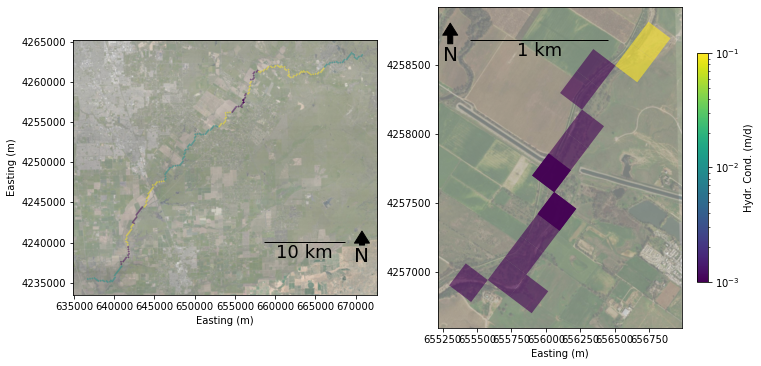

In [78]:
grid_sfr['sfr_K'] = sfr_K
plt_dir = gwfm_dir+'/Blodgett_Dam/figures/'

if grid_sfr.sfr_K.min() >1E-4:
    vmin = grid_sfr.sfr_K.min()
else:
    vmin = 1E-3
    
fig,ax=plt.subplots(1,2,figsize=(12,6))
grid_sfr.plot('sfr_K',ax=ax[0],alpha=0.5,legend=False,
             norm=mpl.colors.LogNorm(vmin=vmin, vmax=grid_sfr.sfr_K.max()))
ctx.add_basemap(ax[0], source = ctx.providers.Esri.WorldImagery, crs='epsg:26910', alpha = 0.6, attribution=False)




K_plot = grid_sfr[(grid_sfr.reach>90)&(grid_sfr.reach<110)].plot('sfr_K',ax=ax[1],alpha=0.6,legend=True, 
                                                                 norm=mpl.colors.LogNorm(vmin=vmin, vmax=grid_sfr.sfr_K.max()),
                                                                legend_kwds={'shrink':0.7,'label':'Hydr. Cond. (m/d)'})
# ax[1].colorbar(shrink=0.7)
ctx.add_basemap(ax[1], source = ctx.providers.Esri.WorldImagery, crs='epsg:26910', alpha = 0.6, attribution=False)
ax[0].ticklabel_format(style='plain')
ax[1].ticklabel_format(style='plain')

ax[0].set_xlabel('Easting (m)')
ax[1].set_xlabel('Easting (m)')
ax[0].set_ylabel('Easting (m)')
x, y, arrow_length = 0.95, 0.25, 0.1,
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0].transAxes), ax[0].ticklabel_format(style='plain')

x, y, arrow_length = 0.05, 0.95, 0.1,
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[1].transAxes), ax[1].ticklabel_format(style='plain')

fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax[0].transData,
                               10000, '10 km', loc='lower right', 
                               pad=1.7, sep=2, color='black',
                               frameon=False, size_vertical=1,
                               fontproperties=fontprops),
ax[0].add_artist(scalebar[0])

scalebar = AnchoredSizeBar(ax[1].transData,
                               1000, '1 km', loc= 'upper left', 
                               pad=1.7, sep=2, color='black',
                               frameon=False, size_vertical=1,
                               fontproperties=fontprops),
ax[1].add_artist(scalebar[0])
# plt.savefig(plt_dir+scenario+'stream_K_longitudinal mapping.png',dpi=600,bbox_inches='tight')

In [122]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')


## Define segment data

In [123]:
sfr_seg = sfr.segment_data[0].copy()

In [124]:
# 15.0=14, 16.2 = 15, 16.4 = 16, 16.5 = 17, 17.0=18
# 14 outseg will be the side channel (16), 15 is the diversion before the Dam from 14 iupseg
# outseg for 15 will be -1 for the lake representing BLodgett Dam
# there is a diversion from 15 (segment to Dam) to 16 (side channel) to correct for the flood diversion
# so that below 500 cfs flow only goes to the side channel and above 500 cfs flow is 80% to Dam and 20% to side channel
# based on the idea that the side channel has a XS roughly 1/4 the size of the main channel and under high flows there
# will be more depth and force that flow will most likely be dominantly straight and avoid the side channel more
if scenario =='actual':
    pre_seg = XSg.loc[XSg.Site==16.2,'iseg'].iloc[0]
    side_seg = XSg.loc[XSg.Site==16.4,'iseg'].iloc[0]
    rout_seg = XSg.loc[XSg.Site==16.3,'iseg'].iloc[0]
    print(pre_seg, side_seg)
if (scenario =='actual') | (scenario=='design'):
    post_seg = XSg.loc[XSg.Site==16.5,'iseg'].iloc[0]
    print(post_seg)

15 17
18


In [125]:
# there is roughly 1000 sq. m inundated by the Blodgett Dam under lower flow conditions
# (with 1000 m^2 being generous/assuming more than actual
dam_area = 1000
# ksat_guess = 0.01 # m/day, silty
ksat_guess = 1 # sandy
flow_guess = ksat_guess*dam_area
cfs_guess = flow_guess/(0.3048**3)/86400
# assuming head gradient is 1.5, roughly 3 ft deep and may be 6 ft clogging layer we would have 9/6 = 1.5
print('Seepage average (m^3/d)',flow_guess*1.5, 'seep avg (cfs)',cfs_guess*1.5)
print( 'Seepage as % of flow:', cfs_guess*1.5/25,' for 25 cfs', cfs_guess*1.5/150, 'for 150 cfs')
dam_div = 0.05 # set the diversion as 5% of given streamflow as conservative estimate
# assuming the sandy hydraulic conductivity and a disconnected aquifer, we would expect for very low flows a high 
# of around 2.5% of flow seeping into the ground, we could assume more water going in because of more area under higher flow

Seepage average (m^3/d) 1500.0 seep avg (cfs) 0.6131018528036212
Seepage as % of flow: 0.024524074112144845  for 25 cfs 0.004087345685357475 for 150 cfs


## Need to adjust segment connections to add or remove LAK under different scenarios

In [126]:
# alternate version of segment data loading using if statements when filtering data rather than in a loop
sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion
# correct outseg and iupseg to account for Blodgett Dam scenario
if scenario =='design':
    sfr_seg.outseg[sfr_seg.nseg==post_seg-1]=0 # segment before dam flows to RIV and so "leaves" domain, assume fills up dam
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg]=-1 # lake outflow is diverted to segment after dam
elif scenario == 'actual':
    # given that dam is only used a low flows, dam will divert a steady 20%
    sfr_seg.outseg[sfr_seg.nseg==pre_seg-1] = side_seg # the river should flow to the side segment first
     # there will be a diversion from the river to the dam above 500 cfs, of which 20% will be returned to the side channel
    sfr_seg.iupseg[sfr_seg.nseg==pre_seg] = pre_seg-1
    sfr_seg.iprior[sfr_seg.nseg==pre_seg] = -2 # iprior=-3 any flows above the flow specified will be diverted
    sfr_seg.flow[sfr_seg.nseg==pre_seg] = dam_div #
    sfr_seg.outseg[sfr_seg.nseg==pre_seg] = 0 #outflow from short segment before Dam is the LAK for the dam, but to nowhere for RIV
    # there is a problem with flow routing to S16 after the diversion to 15 so the remaining diversion will be to S16
    sfr_seg.iupseg[sfr_seg.nseg==side_seg] = pre_seg-1
    sfr_seg.iprior[sfr_seg.nseg==side_seg] = -2 # iprior=-3 any flows above the flow specified will be diverted
    sfr_seg.flow[sfr_seg.nseg==side_seg] = 1-dam_div  #(0.3048**3)*86400 # 500 cfs is the start of higher flow in the Cosumnes
    # adjust for flow from pre dam segment back to side channel, remove diversion from dam to side
#     sfr_seg.iupseg[sfr_seg.nseg==side_seg] = pre_seg
#     sfr_seg.iprior[sfr_seg.nseg==side_seg] = -2 # the flow diverted is a % of the total flow in the channel
#     sfr_seg.flow[sfr_seg.nseg==side_seg] = 0.2 # the side channel is about 1/4 the size so 20% of flow should run through
    # divert flow from lake back into the segment after the dam
#     sfr_seg.iupseg[sfr_seg.nseg==rout_seg] = -1 # no need to change iprior because diversion is based on lake stage
    sfr_seg.outseg[sfr_seg.nseg==rout_seg] = post_seg
    # try routing flow from 16 to 18 with a diversionn
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg+1] = side_seg
#     sfr_seg.iprior[sfr_seg.nseg==post_seg+1] = -2
#     sfr_seg.flow[sfr_seg.nseg==post_seg+1] = 1

# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [127]:
sfr.segment_data[0] = sfr_seg

In [128]:
# Pull out data for upstream and downstream reach of each segment
up_data = xs_sfr.drop_duplicates('iseg')
dn_data = xs_sfr.sort_values('reach_new',ascending = False).drop_duplicates('iseg').sort_values('iseg')


# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = sfr.reach_data.strhc1[0]
sfr.segment_data[0].thickm1 = 2
sfr.segment_data[0].elevup = up_data.z.values
sfr.segment_data[0].width1 = 20
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = 0.4
sfr.segment_data[0].thti1 = 0.15
sfr.segment_data[0].eps1 = 4
sfr.segment_data[0].uhc1 = sfr.reach_data.strhc1[0]

# Dataset 6c
sfr.segment_data[0].hcond2 = sfr.reach_data.strhc1[-1]
sfr.segment_data[0].thickm2 = 2
sfr.segment_data[0].elevdn = dn_data.z.values
sfr.segment_data[0].width2 = 20
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = 0.4
sfr.segment_data[0].thti2 = 0.15
sfr.segment_data[0].eps2 = 4
sfr.segment_data[0].uhc2 = sfr.reach_data.strhc1[-1]


In [129]:
# Change column name to float type for easier referencing in iteration
XS8pt.columns = XS8pt.columns.astype('float')
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(2,len(XSg)+2)}  }

xsnum = 2
for k in XSg.Site.values:
        pos = int(XS8pt.columns.get_loc(k))
        XCPT = XS8pt.iloc[:,pos].values
        ZCPT = XS8pt.iloc[:,pos+1].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [130]:
FLOWTAB = mb4rl.discharge_va.values
DPTHTAB = mb4rl.gage_height_va.values
WDTHTAB = mb4rl.chan_width.values
sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

## Test a range of flows for the scenarios
Because we are looking at all low flow scenarios we are assuming that river disconnection has already occurred and that the boards for the dam were previously installed
1. Dam is typically installed around 75 cfs when disconnection occurs
2. Dam can be used up to 100 cfs or so
3. Dam is most likely continued in use until river is dry 25 cfs
4. It would be interesting to test the scenario of higher flows with the dam in place, 150 cfs


Test with Riv package at two depths each assumed for 25 and 100 cfs
*No changes to LAK package are necessary for individual scenarios*

In [131]:
# flows_cfs = np.asarray([25, 75, 100, 150])
flows_cfs = np.asarray([25, 100])

flows_cmd = flows_cfs *(0.3048**3)*86400


In [132]:
# m.write_input()
# sfr.write_file()

# m.remove_package("LAK")
# m.remove_package("DATA")

In [133]:
blodgett = XSg.loc[XSg.Site==16.5]
blodgett.row.values-1

array([52.])

## RIV package

In [6]:
## need to update ibound array to have noflow cell at first cell under lake
bath = np.loadtxt(gwfm_dir+'/LAK_data/Blodgett_bath.txt')
# bath[:,0] = bath[:,0]+10*0.3048 # remove the artifical 10 ft lowering from LAK package
bath

array([[1.99400000e+01, 0.00000000e+00, 0.00000000e+00],
       [1.99600000e+01, 3.52216601e-02, 1.81451250e+00],
       [1.99900000e+01, 1.65279119e-01, 5.44353750e+00],
       [2.00200000e+01, 4.39727388e-01, 1.17943313e+01],
       [2.00500000e+01, 8.87802486e-01, 1.81451250e+01],
       [2.00700000e+01, 1.36338661e+00, 2.90322000e+01],
       [2.01000000e+01, 2.42007275e+00, 4.62700688e+01],
       [2.01300000e+01, 4.10415402e+00, 6.80442187e+01],
       [2.01600000e+01, 6.59141684e+00, 9.61691625e+01],
       [2.01800000e+01, 8.71501264e+00, 1.10685263e+02],
       [2.02100000e+01, 1.25412990e+01, 1.37902950e+02],
       [2.02400000e+01, 1.73719201e+01, 1.76007712e+02],
       [2.02700000e+01, 2.33237594e+01, 2.26814063e+02],
       [2.02900000e+01, 2.81760804e+01, 2.73991388e+02],
       [2.03200000e+01, 3.81726240e+01, 4.41833794e+02],
       [2.03500000e+01, 5.47202562e+01, 6.82256700e+02],
       [2.03800000e+01, 7.96693601e+01, 9.64413394e+02],
       [2.04000000e+01, 1.00882

In [7]:
0.01*1993*2.5255/1.5255, 0.01*3771*3.5255/1.5255

(32.99456899377253, 87.14952802359882)

In [2]:
200*200*0.01/1.5255

262.2091117666339

In [135]:
# assume actual depth is 1 and 2 m with side channel
actual_depths = bath[0,0] + [1,2]
# assume design depth is 2.5 and 5m without side channel
design_depths = bath[0,0] + [2.5, 4]
if scenario == 'design':
    depths = design_depths
elif scenario == 'actual':
    depths = actual_depths

In [136]:
# vertK * Area / thickness, K and thickness are constant
lkbd_thick = sfr.reach_data.strthick[XSg.loc[XSg.Site==16.5].reach][0]
lkbd_K = sfr_K[XSg.loc[XSg.Site==16.5].reach][0]
# k,i,j
rlay,rrow,rcol = 0, int(blodgett.row.values[0]-1), int(blodgett.column.values[0]-1)


In [137]:
# no inactive cells needed if LAK package not used
# m.bas6.ibound = np.ones(m.dis.botm.shape)
# m.bas6.write_file()

## Write SFR and RIV (LAK) output

In [139]:
# set a flow into segment 1 for the steady state model run
for n in np.arange(0,2):
# n=2
    sfr.segment_data[0].flow[0] = flows_cmd[n] # m3/day, originally 15 m3/s
    print(flows_cmd[n])
    loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_RIV_scenarios/'
    m.model_ws = loadpth+scenario+'_'+str(flows_cfs[n]).zfill(4)+'cfs'

    lak_stage,lak_area = bath[np.min(np.where(depths[n]<bath[:,0])),0:2]
    cond = lkbd_K * lak_area / lkbd_thick
    riv_spd = np.asarray([rlay,rrow, rcol,lak_stage, cond, bath[0,0] ])
    riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd,ipakcb=55)
#     m.write_input()
#     sfr.write_file()
    riv.write_file()

61164.38863872001

changing model workspace...
   C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_RIV_scenarios/actual_0025cfs
Errors and/or Warnings encountered.
Errors and/or Warnings encountered.
  see C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_RIV_scenarios/actual_0025cfs\RIV.chk for details.

244657.55455488004

changing model workspace...
   C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_RIV_scenarios/actual_0100cfs
Errors and/or Warnings encountered.
Errors and/or Warnings encountered.
  see C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_RIV_scenarios/actual_0100cfs\RIV.chk for details.



In [95]:
riv.check()

Errors and/or Warnings encountered.

RIV PACKAGE DATA VALIDATION:
  1 Warning:
    1 instance of BC in inactive cell

  Checks that passed:
    stage below cell bottom
    rbot below cell bottom
    RIV stage below rbots



In [116]:
m.get_package_list()

['DIS', 'BAS6', 'LPF', 'GHB', 'CHD', 'RCH', 'WEL', 'OC', 'PCGN', 'SFR', 'RIV']

## LAK package

In [46]:
nrow = m.dis.nrow
ncol = m.dis.ncol

array([1.5255], dtype=float32)

In [56]:
# Set empty array of zeros for nonlake cells
lakarr = np.zeros((nlay, nrow,ncol))
# Each lake is given a different integer, and needs to be specified depending on the layer
lakarr[0,(blodgett.row.values-1).astype(int),(blodgett.column.values-1).astype(int)] = 1

bdlknc = np.zeros(( nrow,ncol))
# set blodgett dam Ksat same as stream Ksat at same location, leakance is K/lakebed thickness
lkbd_thick = sfr.reach_data.strthick[XSg.loc[XSg.Site==16.5].reach]
lkbd_K = sfr_K[XSg.loc[XSg.Site==16.5].reach]
bdlknc[(blodgett.row.values-1).astype(int),(blodgett.column.values-1).astype(int)] = lkbd_K/lkbd_thick

In [72]:
# set ibound cell to zero where lake is
ibound = m.bas6.ibound.array
ibound[lakarr==1]=0
m.bas6.ibound = ibound

m.bas6.write_file()

In [49]:
lakeRst = rasterio.open(gwfm_dir+'/Blodgett_Dam/geospatial/DEMs/hecras_1m_bathymetry.tif')
lakeBottom = lakeRst.read(1)
noDataValue = np.copy(lakeBottom[0,0])
#replace value for np.nan
lakeBottom[lakeBottom==noDataValue]= np.nan
# the stage for the stream section just after the dam is 23.04 m thus the bottom of the lake must be set 10 ft below that
lakeBottom = lakeBottom - 10
lakeBottom *= 0.3048

# get raster minimum and maximum 
minElev = np.nanmin(lakeBottom)
maxElev = np.nanmax(lakeBottom)
print('Min bottom elevation %.2f m., max bottom elevation %.2f m.'%(minElev,maxElev))

# steps for calculation
nSteps = 151
# lake bottom elevation intervals
elevSteps = np.round(np.linspace(minElev,maxElev,nSteps),2)


NameError: name 'rasterio' is not defined

In [48]:
lakeBottom

NameError: name 'lakeBottom' is not defined

In [474]:
# definition of volume function
def calculateVol_A(elevStep,elevDem,lakeRst):
    tempDem = elevStep - elevDem[elevDem<elevStep]
    tempArea = len(tempDem)*lakeRst.res[0]*0.3048*lakeRst.res[1]*0.3048
    tempVol = tempDem.sum()*lakeRst.res[0]*0.3048*lakeRst.res[1]*0.3048
    return(tempVol, tempArea)
# calculate volumes, areas for each elevation
volArray = [0]
saArray = [0]
for elev in elevSteps[1:]:
    tempVol,tempArea = calculateVol_A(elev,lakeBottom,lakeRst)
    volArray.append(tempVol)
    saArray.append(tempArea)
    

## Artificial lowering of lake stage to limit outflow
The stage range of the lake is artifically reduced by 10 ft to account for the implementation of Blodgett Dam during the winter as outflow from a LAK to SFR reach is calculated using the lake stage minus the stream bottom thus when the lake depth reaches 10 ft the top of the lake will be at the bottom of the stream bottom and start flowing out to the channel.


In [475]:
# Exactly 151 lines must be included within each lake bathymetry input file and each line must contain 1 value 
#  of lake stage (elevation), volume, and area (3 numbers per line) if the keyword “TABLEINPUT” is specified in item 1a.
# A separate file is required for each lake. 

stages = minElev+0.1
# (ssmn, ssmx) max and min stage of each lake for steady state solution, there is a stage range for each lake
# so double array is necessary
stage_range = [[minElev, maxElev]]

# lake stage (elevation), volume, and area (3 numbers per line)
lak_depth = elevSteps - elevSteps[0]
bathtxt = np.column_stack((elevSteps, volArray, saArray))

np.savetxt(m.model_ws+'/MF.txt', bathtxt, delimiter = '\t')


In [476]:
## Need to specify flux data
# Dict of lists keyed by stress period. The list for each stress period is a list of lists,
# with each list containing the variables PRCPLK EVAPLK RNF WTHDRW [SSMN] [SSMX] from the documentation.
# flux_data = np.zeros((nrow,ncol))

# flux_data = {0:{0:[0,0,0,0]}}

# # filler value for bdlknc until soil map data is loaded by uzf
# lak = flopy.modflow.ModflowLak(model = m, lakarr = lakarr, bdlknc = bdlknc,  stages=stages, 
#                                stage_range=stage_range, flux_data = flux_data,tabdata= True, 
#                                tab_files='MF.txt', tab_units=[57],ipakcb=55)

# # the lak package doesn't specify the tab file unit number when the files are written
# # example:      110.0     100.0     170.0   22   Item 3:  STAGES,SSMN,SSMX,IUNITLAKTAB
# lak.options = ['TABLEINPUT']

In [477]:
# lak.theta
# lak.sscncr=0.01
# # need to reset tabdata as True before writing output for LAK
# lak.tabdata = True

In [615]:
# flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'txt',unitnumber = 57)

Outside Package class

### Gage file for output

In [613]:
# numgage is total number of gages
# gage_data (list, or array), includes 2 to 3 entries (LAKE UNIT (OUTTYPE)) for each LAK entry
#  4 entries (GAGESEG< GAGERCH, UNIT, OUTTYPE) for each SFR package entry
lak_gage_data = [[-1, -37, 1]]
lak_file = 'MF.lak.gage'
lak_file_out = 'MF.lak.gage.out'
gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=lak_gage_data,file =[lak_file_out], filenames =[lak_file])


## Summary of model fluxes

## Output Control

In [63]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}

  
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

In [64]:
# iter_mo max outer iters, ter_mi = max inner iters, close_r residual criterion for stopping iteration
# close_h is alternate criterion for nonlinear problem, and is head closure which should be smaller than residual closer
# ipunit =0 means no info on solver, ipunit=1 means output about solver issues is written
# if iter_mo >1 then closer_r is used not close_h and closer_r is compared to 
# the square root of the inner product of the residuals (the residual norm)
# adamp =0 is std damping, adamp=1 is adaptive damping that further decreases or increases damping based on picard
# iteration sucess
#adamp is 0.7 to resolve issues with heads oscillating near solution +1 m
# damp_lb = lower bound, rate_d is rate of increase of damping based picard iteration success
pcgn = flopy.modflow.ModflowPcgn(m, iter_mo = 100, iter_mi=60, close_r=1e-01, close_h=1e-02, ipunit=28)
#                                adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)

In [215]:
m.get_package_list()
# m.remove_package('DATA')
# m.remove_package('RIV')
# m.remove_package('WEL')
# m.remove_package('RCH')
# m.remove_package('NWT')

['DIS',
 'SFR',
 'BAS6',
 'LPF',
 'GHB',
 'CHD',
 'RCH',
 'WEL',
 'OC',
 'PCGN',
 'LAK',
 'DATA']

In [216]:

m.check()
# lak.check()
# upw.check()


MF MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000.0
    LP

## Write the input files

In [356]:
# Writing the MODFLOW data files
m.write_input()


# Run the model
with batch file

In [11]:
loadpth = 'C://WRDAPP/GWFlowModel/Cosumnes_Blodgett_scenarios/'

runs = os.listdir(loadpth)
runs

['actual_0025cfs',
 'actual_0075cfs',
 'actual_0100cfs',
 'actual_0150cfs',
 'design_0025cfs',
 'design_0075cfs',
 'design_0100cfs',
 'design_0150cfs',
 'new_0025cfs',
 'new_0075cfs',
 'new_0100cfs',
 'new_0150cfs']

In [54]:
# import shutil, os


# for n in np.arange(1,8).astype(str):
#     for f in files:
#         folder = '/r'+ n.zfill(2)+'/'
#         os.makedirs(m.model_ws+folder,exist_ok=True)
#         shutil.copy(f, m.model_ws+folder)